# Knowledge Discovery and Data Mining
# Exercise 4: Naive Bayes, Support Vector Machine

## Exercise 4-3 - Naive Bayes and SVM (Solution)


In this tutorial, we want you to try out Naive Bayes and SVM classifiers to analyze the given data.

# Naive Bayes with Continuous Attributes

In the provided `data.csv`, find will find a small dataset with covariates $x_1$ and $x_2$ together with a binary target $y$.

Load the dataset.

In [1]:
import numpy as np
data = np.loadtxt('data.csv', skiprows=1, delimiter=',')
x1 = data[:,0]
x2 = data[:,1]
y = data[:,2]

Fit an `sklearn.naive_bayes.GaussianNB` classifier to $X=[x_1,x_2]$ (model1) and $X=[x_1]$ (model2)
and plot the predicted probabilities dependent on x1. What do you observe?

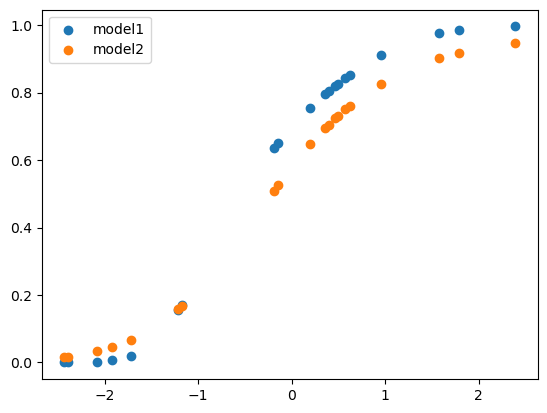

In [2]:
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
model1 = GaussianNB(var_smoothing=0)
model1.fit(np.stack([x1,x2], axis=1), y)
y_pred1 = model1.predict_proba(np.stack([x1, x2], axis=1))

model2 = GaussianNB(var_smoothing=0)
model2.fit(x1.reshape(-1,1), y)
y_pred2 = model2.predict_proba(x1.reshape(-1,1))

plt.scatter(x1, y_pred1[:,1], label='model1')
plt.scatter(x1, y_pred2[:,1], label='model2')
plt.legend()
plt.show()

Model1 is more confident in its predictions.

Explore the features x1 and x2 (conditioned on y).

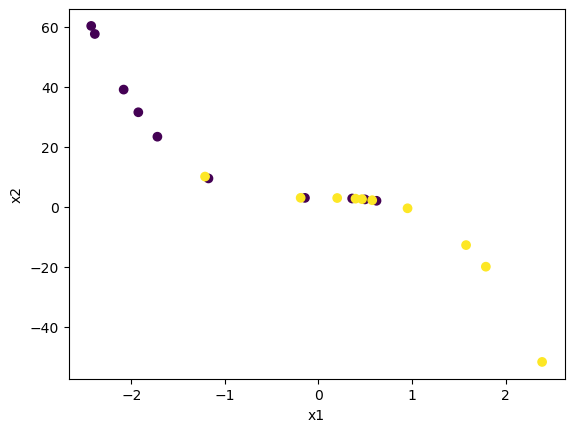

In [3]:
plt.scatter(x1, x2, c=y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Apparently, $x_1$ and $x_2$ are not (conditionally) independent.

Now, assume $x_2 = f(x_1)$ where $f$ is a bijection (based of what we have seen, this is reasonable).

Calculate the formula for the posterior probabilities $P(y=1|x_1,x_2)$ for model1 as well as model2 (which is the realization of our assumption about $x_1$ and $x_2$). Based on that, explain the issue with model1.

Model1:

\begin{eqnarray*}
P(y=1|x_1,x_2) &=& \frac{P(y=1)P(x_1,x_2|y=1)}{P(y=1)P(x_1,x_2|y=1) + P(y=0)P(x_1,x_2|y=0)}\\
&=& \frac{P(y=1)P(x_1|y=1)P(x_2|y=1)}{P(y=1)P(x_1|y=1)P(x_2|y=1) + P(y=0)P(x_1|y=0)P(x_2|y=0)}\\
&=& \frac{P(y=1)P(x_1|y=1)^2}{P(y=1)P(x_1|y=1)^2 + P(y=0)P(x_1|y=0)^2}\\
&=& \frac{P(x_1|y=1)^2}{P(x_1|y=1)^2 + P(x_1|y=0)^2}
\end{eqnarray*}

Model2 (assuming $x_2 = f(x_1)$):
\begin{eqnarray*}
P(y=1|x_1,x_2) &=& \frac{P(y=1)P(x_1,x_2|y=1)}{P(y=1)P(x_1,x_2|y=1) + P(y=0)P(x_1,x_2|y=0)}\\
&=& \frac{P(y=1)P(x_1|y=1)}{P(y=1)P(x_1|y=1) + P(y=0)P(x_1|y=0)}\\
&=& \frac{P(x_1|y=1)}{P(x_1|y=1) + P(x_1|y=0)}
\end{eqnarray*}

Naive Bayes makes the assumption that covariates are conditionally independent. This is not the case here, leading to overconfident probability estimates for model1. Model2 is specified correctly.

# Conditional Indepence

Give examples of events A,B,C such that
* A, B are independent conditioned on C but not independent in general
* A, B are not independent conditioned on C, but independent in general

Imagine rolling two dice.

* A="first die is 5 or greater and second die is not 6", B="second die is 5 or greater and first die is not 6", C="both are 5 or greater"


* A="first die is 5 or greater", B="second die is 5 or greater", C="sum is 10 or greater" 

# Linear SVM

Implement your own class of a Hard-margin Linear SVM. The optimization should be performed on the primal problem. Your `fit` method should store the support vectors.

Hint: For the optimization, use `scipy.optimize.minimize`.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class SVM:
    def fit(self, X, y, verbose=False):
        '''
        Values of y are -1 or 1.
        '''
        eps = 1e-10
        def objective(w):
            return w[:-1] @ w[:-1].T
    
        # we encode b as the last element of w
        cons = {'type': 'ineq', 'fun': lambda w: y * (X @ w[:-1] + w[-1]) - 1}
        res = minimize(objective, np.zeros(X.shape[1]+1), constraints=cons)
        
        if verbose:
            print(res)

        self.w = res.x[:-1]
        self.b = res.x[-1]

        train_scores = X @ self.w + self.b
        self.support_vectors = X[np.abs(train_scores) < 1 + eps]
        
    def predict(self, X, labels=True):
        scores = X @ self.w + self.b
        if labels:
            return np.sign(scores)
        else:
            return scores      

Train your SVM on the following data.

In [5]:
np.random.seed(0)
X = np.random.uniform(size=(20,2))
y = (X[:,0] + 2 * X[:,1] > 2) * 2 - 1

In [6]:
svm = SVM()
svm.fit(X,y, verbose=True)
y_pred = svm.predict(X)

     fun: 1989.0106183566031
     jac: array([19.34396362, 87.07383728,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([  9.67198019,  43.53692017, -37.44525568])


Visualize the results:
* plot the datapoints with the predicted labels encoded with color
* plot the decision boundaries and the two margin boundaries (Hint: `plt.contour`)
* mark the support vectors

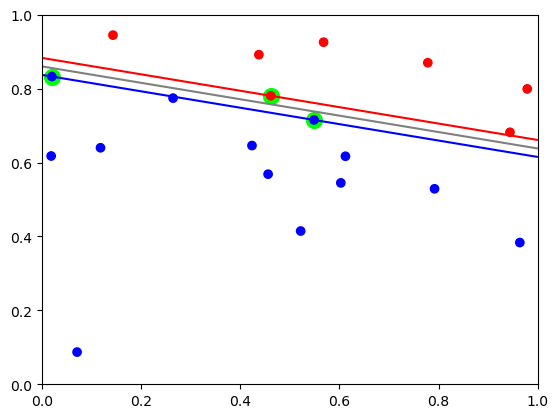

In [7]:
plt.scatter(svm.support_vectors[:,0], svm.support_vectors[:,1], s=128, c='lime')
plt.scatter(X[:,0], X[:,1], c=['r' if y_i==1 else 'b' for y_i in y_pred ])


xx, yy = np.meshgrid(np.linspace(0, 1, 30), np.linspace(0, 1, 30))
z = svm.predict(np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1), labels=False)
z = z.reshape(xx.shape)
plt.contour(xx, yy, z, levels=[-1,0,1], colors=['blue', 'gray', 'red'])
plt.show()